Note:  For now the code cells must be opened for the dropdown lists to work correctly.

In [34]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Clean Air Act Violations and Enforcement by Congressional District

This notebook examines ECHO data using ICIS-AIR_VIOLATION_HISTORY.
The HPV_DAYZERO_DATE reporting the start date of every episode of 
High Priority Violation (HPV) is used.  The PGM_SYS_ID facility
identifier is linked to the ECHO_EXPORTER table's 

A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


In [2]:
#data_location = "https://github.com/edgi-govdata-archiving/echo-data/blob/master/ECHO_EXPORTER.csv?raw=true" # Where the ECHO data is saved
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where  e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and f.ZIP_CODE=%s" %(my_zip)
#sql='show tables'  
#sql= 'show columns from `ECHO_EXPORTER` '

sql = "select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20AIR_IDS%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27


In [3]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)

# local_data_location = "../../ICIS_Air_Violation/ECHO_EXPORTER-Air.csv"
# echo_data = pd.read_csv(local_data_location,encoding='iso-8859-1',header = 0)


In [4]:
states = ["all", "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='all',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', options=('all', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA…

In [55]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 839 ICIS facilities in WA tracked in the ECHO database.


In [56]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=0,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10), value=0)

In [67]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 81 ICIS facilities in WA district 2 tracked in the ECHO database.


Next look up the compliance history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [68]:
sql = "select PGM_SYS_ID, HPV_DAYZERO_DATE, POLLUTANT_DESCS, AGENCY_TYPE_DESC from `ICIS-AIR_VIOLATION_HISTORY` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "PGM_SYS_ID", inplace=True)


In [69]:
# The AIR_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in ICIS-AIR_VIOLATION_HISTORY.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.AIR_IDS
    # Look at each AIR_ID belonging to the facility
    for air_id in ids.split():
        try:
            # Find the air_id in the ICIS-AIR_VIOLATION_HISTORY, if any exist there.
            # It can match a PGM_SYS_ID, which is the index of icis_data.
            air_data = icis_data.loc[ air_id ]
            # Add the facility's index number to air_data, to refer to it.
            # (Generates a SettingWithCopyWarning?)
            n = air_data.shape[0]
            fac_list = [fac.Index] * n
            air_data['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [my_cd_icis, air_data]
            my_cd_icis = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in ICIS-AIR_VIOLATION_HISTORY.
            no_data_ids.append( air_id )
 
my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

/home/steve/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Map the facilities that have had these serious CAA violations.

In [70]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]

In [71]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [72]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()
cd_array


array(['ANDEAVOR ANACORTES REFINERY',
       'AVIATION TECHNICAL SERVICES HANGAR 1', 'BAYLINER MARINE SITE',
       'BOEING COMMERCIAL AIRPLANE GROUP EVERETT', 'CHEMTRADE',
       'ENCOGEN NORTHWEST COGENERATION PLANT',
       'FREDONIA GENERATING STATION', 'KIMBERLY CLARK EVERETT MILL SITE',
       'MARCH POINT COGENERATION SITE',
       'NAVAL AIR STATION WHIDBEY ISLAND', 'PACIFIC WOODTECH',
       'SHELL OIL PRODUCTS US PUGET SOUND REFINERY',
       'SIERRA PACIFIC INDUSTRIES'], dtype=object)

In [73]:
w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('ANDEAVOR ANACORTES REFINERY', 'AVIATION TECHNICAL SERVICES HA…

In [106]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
my_violations = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]
my_violations


,0,AGENCY_TYPE_DESC,HPV_DAYZERO_DATE,POLLUTANT_DESCS,facility,HPV_DAYZERO_YEAR
WANCA0005307300032,NaN,Local,05-16-2005,NITROGEN OXIDES NO2,11191.0,2005.0
WANCA0005307300032,NaN,Local,07-27-2007,Ammonia,11191.0,2007.0
WANCA0005307300032,NaN,Local,NaN,NaN,11191.0,NaN


## Plot the number of violations by year, using the entire state.
For this we can use the statewide numbers, as they will be small for individual districts.

In [87]:
import datetime

format_str = '%m-%d-%Y' # The format
nan_count = 0
year_col = []
for day in icis_data['HPV_DAYZERO_DATE']:
    try:
        viol_year = datetime.datetime.strptime(day, format_str).year
        year_col.append( viol_year )
    except:
        nan_count += 1
        year_col.append(  np.NaN )
icis_data['HPV_DAYZERO_YEAR'] = year_col
icis_data

,HPV_DAYZERO_DATE,POLLUTANT_DESCS,AGENCY_TYPE_DESC,HPV_DAYZERO_YEAR
PGM_SYS_ID,,,,
WANCA0005307310007,07-23-1997,NaN,Local,1997.0
WANCA0005307310007,10-28-1998,NaN,Local,1998.0
WANCA0005307310007,10-28-1998,NaN,Local,1998.0
WANCA0005307310007,10-19-2005,NITROGEN OXIDES NO,Local,2005.0
WANCA0005307310007,12-14-2005,Hydrogen sulfide,Local,2005.0
...,...,...,...,...
WASPC0005306310033,09-08-2006,Sodium cyanide,Local,2006.0
WAPSC0000000010126,03-19-2019,Sulfur dioxide,Local,2019.0
WASWC0005301500148,NaN,NaN,Local,NaN


                  HPV_DAYZERO_DATE
HPV_DAYZERO_YEAR                  
1992.0                           2
1993.0                           3
1994.0                           7
1995.0                           4
1996.0                          10
1997.0                          55
1998.0                          78
1999.0                          49
2000.0                          57
2001.0                          22
2002.0                          25
2003.0                          31
2004.0                          24
2005.0                          25
2006.0                          21
2007.0                          24
2008.0                          24
2009.0                          15
2010.0                          11
2011.0                          15
2012.0                          16
2013.0                           5
2014.0                           4
2015.0                           8
2016.0                          10
2017.0                           4
2018.0              

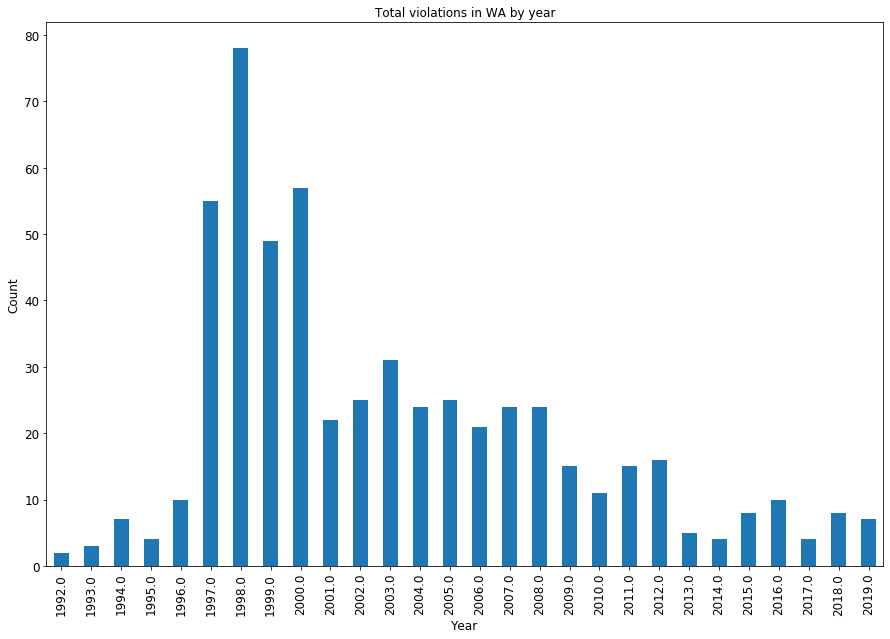

In [104]:
year_groups = icis_data.groupby("HPV_DAYZERO_YEAR")[["HPV_DAYZERO_DATE"]]
counted_years = year_groups.count()

# Print how many values are present 
print(counted_years)
chart_title = "Total violations in " + my_state + " by year"

ax = counted_years[['HPV_DAYZERO_DATE']].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

